In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization



/Users/ville/repos/Ai-teori och tillämpning, del2/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Data

In [2]:
#CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

#train 3000images 
limit = 3000
x_train = x_train[:limit]
y_train = y_train[:limit]
x_test = x_test[:limit]
y_test = y_test[:limit]


#scale pixel values from 0-255 to the range 0-1
#scaling to 0-1 helps the network find optimal weights and converge faster.
x_train = x_train / 255.0
x_test = x_test / 255.0

# checking dimensions
print(np.shape(x_train))

(3000, 32, 32, 3)


/Users/ville/repos/Ai-teori och tillämpning, del2/.venv/lib/python3.13/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


## EDA

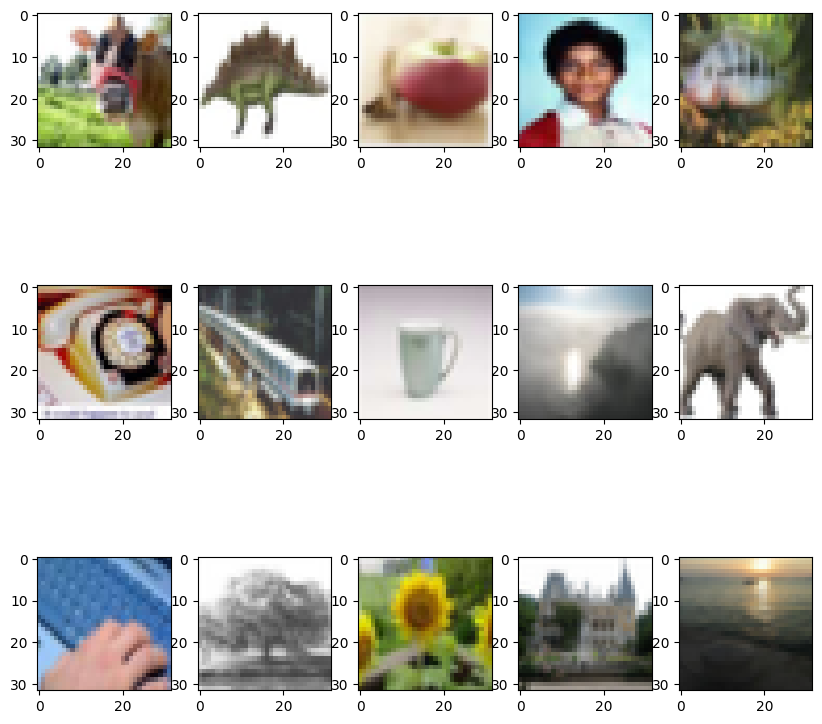

In [3]:
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(x_train[i])
    plt.axis('on')

## A: Basemodel

In [4]:
model = Sequential()

model.add(Input(shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.0108 - loss: 4.6074 - val_accuracy: 0.0267 - val_loss: 4.6002
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.0262 - loss: 4.5320 - val_accuracy: 0.0233 - val_loss: 4.4898
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.0446 - loss: 4.3387 - val_accuracy: 0.0433 - val_loss: 4.2858
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.0688 - loss: 4.1510 - val_accuracy: 0.0567 - val_loss: 4.1730
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.0883 - loss: 3.9550 - val_accuracy: 0.0667 - val_loss: 4.1080
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.1142 - loss: 3.8174 - val_accuracy: 0.0800 - val_loss: 3.9980
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.1462 - loss: 3.6149 - val_accuracy: 0.1133 - val_loss: 3.8826
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.1875 - loss: 3.4236 - val_accuracy: 0.

## prediction

In [5]:
# Make predictions and evaluate the model
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = np.mean(y_pred_labels == y_test.flatten())
print(f"Accuracy: {accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.12766666666666668


## B: Hyperparameter Tuning with Keras Tuner

In [6]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model.add(Conv2D(filters=hp.Int('conv_1', 32, 64, step=32), kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=hp.Int('conv_2', 64, 128, step=32), kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Conv2D(filters=hp.Int('conv_3', 128, 256, step=64), kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Flatten())
    model.add(Dense(hp.Int('dense_1', 256, 512, step=128), activation='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(100, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 1. make tuners
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuning_results',
    project_name='cifar100_v2',
    overwrite=True
)

# 2. start 
tuner.search(x_train, y_train, epochs=10, validation_split=0.2)

tuner.results_summary()

Trial 5 Complete [00h 03m 09s]
val_accuracy: 0.029999999329447746

Best val_accuracy So Far: 0.1316666603088379
Total elapsed time: 01h 32m 34s
Results summary
Results in tuning_results/cifar100_v2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
conv_1: 64
conv_2: 128
dropout_1: 0.2
conv_3: 128
dropout_2: 0.4
dense_1: 384
lr: 0.0001
Score: 0.1316666603088379

Trial 3 summary
Hyperparameters:
conv_1: 32
conv_2: 64
dropout_1: 0.4
conv_3: 128
dropout_2: 0.2
dense_1: 512
lr: 0.0001
Score: 0.11666666716337204

Trial 0 summary
Hyperparameters:
conv_1: 32
conv_2: 128
dropout_1: 0.30000000000000004
conv_3: 128
dropout_2: 0.4
dense_1: 384
lr: 0.0001
Score: 0.09333333373069763

Trial 1 summary
Hyperparameters:
conv_1: 32
conv_2: 96
dropout_1: 0.2
conv_3: 128
dropout_2: 0.4
dense_1: 512
lr: 0.001
Score: 0.06833333522081375

Trial 4 summary
Hyperparameters:
conv_1: 64
conv_2: 64
dropout_1: 0.4
conv_3: 192
dropout_2: 0.30000000000000004
dense

## C: Transfer Learning with MobileNetV2

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

# 1. Load a pre-trained model without the top layer (include_top=False)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# 2. Freeze the base model to prevent destroying the pre-trained weights
base_model.trainable = False

# 3. build with own layers
model_tl = Sequential([
    base_model,
    GlobalAveragePooling2D(), # Förenklar datan från basmodellen
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(100, activation='softmax') # 100 klasser för CIFAR-100
])

model_tl.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_tl = model_tl.fit(x_train, y_train, epochs=10, validation_split=0.2)

/var/folders/zh/rjx9yzgn0_v4p4g4830nbtwm0000gn/T/ipykernel_79989/2085634796.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.0150 - loss: 4.5900 - val_accuracy: 0.0350 - val_loss: 4.5482
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0538 - loss: 4.4492 - val_accuracy: 0.0483 - val_loss: 4.4604
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0675 - loss: 4.2929 - val_accuracy: 0.0533 - val_loss: 4.3494
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0967 - loss: 4.1314 - val_accuracy: 0.0700 - val_loss: 4.2515
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1146 - loss: 4.0064 - val_accuracy: 0.0817 - val_loss: 4.1782
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1271 - loss: 3.9079 - val_accuracy: 0.0950 - val_loss: 4.1396
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1508 - loss: 3.8091 - val_accuracy: 0.0933 - val_loss: 4.1016
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1708 - loss: 3.7191 - val_accuracy: 0.0983 - v